In [1]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew in

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [3]:
df_train["outliers"] = np.where(df_train.target < -30, 1, 0)

In [4]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [5]:
df_train, df_test = merge_new_feature("../input/feature_categorical_count.csv")
df_train, df_test = merge_new_feature("../input/feature_categorical_rete__by__categorical_count.csv")
df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/feature_catogorical_count_weighted_elapsed.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")
df_train, df_test = merge_new_feature("../input/feature_term_from_second_latest_to_latest.csv")
df_train, df_test = merge_new_feature("../input/feature_nunique_marchant__per__card_id.csv")
df_train, df_test = merge_new_feature("../input/feature_purchase_amount_mean_max_increase.csv")
df_train, df_test = merge_new_feature("../input/feature_frequency_mean_increase_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_card_count_increase_rate.csv")

In [7]:
dont_use = ['card_id', 'first_active_month','target', 'feature', 'outliers']

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['outliers']

In [8]:
categorical = [
    "feature_1"
    , "feature_2"
    , "feature_3"
]

In [9]:
#original
param = {
    'num_leaves': 31, 
    'min_data_in_leaf': 30,
    'objective':'binary', 
    'max_depth': 8, 
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'auc',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx], categorical_feature=categorical)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx], categorical_feature=categorical)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

roc_auc_score(target, oof)

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's auc: 0.894236	valid_1's auc: 0.877692
[200]	training's auc: 0.913687	valid_1's auc: 0.884843
[300]	training's auc: 0.927649	valid_1's auc: 0.889181
[400]	training's auc: 0.938419	valid_1's auc: 0.890903
[500]	training's auc: 0.947501	valid_1's auc: 0.891786
[600]	training's auc: 0.955786	valid_1's auc: 0.892665
[700]	training's auc: 0.963158	valid_1's auc: 0.893678
[800]	training's auc: 0.968699	valid_1's auc: 0.894496
[900]	training's auc: 0.972712	valid_1's auc: 0.894704
[1000]	training's auc: 0.976018	valid_1's auc: 0.894829
[1100]	training's auc: 0.978689	valid_1's auc: 0.894879
[1200]	training's auc: 0.981104	valid_1's auc: 0.894846
[1300]	training's auc: 0.983289	valid_1's auc: 0.894973
[1400]	training's auc: 0.985123	valid_1's auc: 0.894923
[1500]	training's auc: 0.986766	valid_1's auc: 0.89509
[1600]	training's auc: 0.988133	valid_1's auc: 0.895206
[1700]	training's auc: 0.989398	valid_1's au

0.8901216210718954

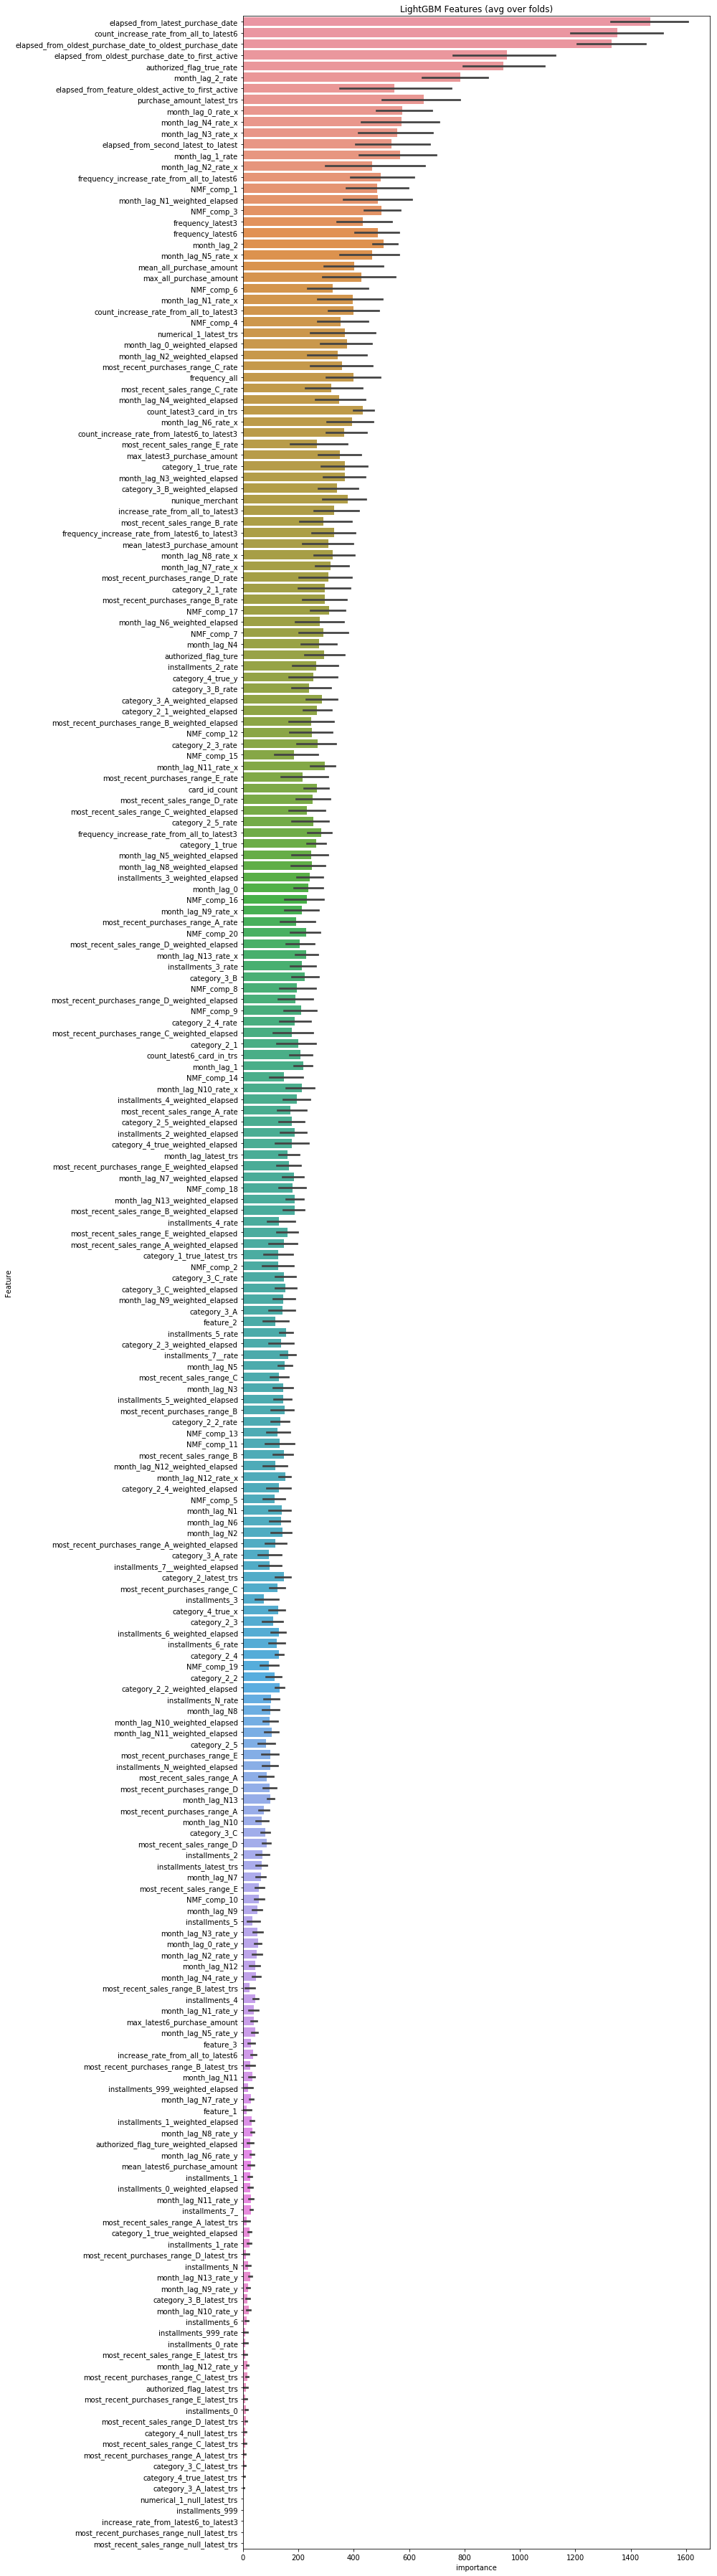

In [10]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

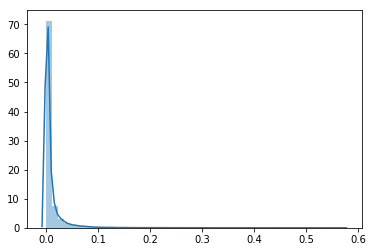

In [11]:
sns.distplot(predictions)

In [27]:
submission = pd.DataFrame({"card_id":df_test.card_id, "outliers_prob":predictions})

In [28]:
submission

,card_id,outliers_prob
0,C_ID_0ab67a22ab,0.012885
1,C_ID_130fd0cbdd,0.001781
2,C_ID_b709037bc5,0.003938
3,C_ID_d27d835a9f,0.000258
4,C_ID_2b5e3df5c2,0.003344
5,C_ID_5814b4f13c,0.005885
6,C_ID_a1b3c75277,0.000549
7,C_ID_f7cada36d3,0.017493
8,C_ID_9d2bc8dfc4,0.002156
9,C_ID_6d8dba8475,0.015192


In [29]:
submission.to_csv("../output/outliers_clf_model20190101.csv", index=False)